# **ACML Assigment: Convolutional Autoencoders**

should we put smth about data and reconstruction??

In [1]:
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import random_split
from torchvision.datasets import CIFAR10

import os
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
def get_best_device():
    if torch.backends.mps.is_built():
        device = torch.device("mps")
        print("Using MPS (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using CUDA (GPU)")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

In [3]:
EPOCHS = 10
N_EXAMPLES = 5

## **Exercise 1**

1. Divide your dataset into training (80%), validation (10%) and test (10%). Normalize the data.

In [4]:
BATCH_SIZE = 512

transform_cifar = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)


dataset = CIFAR10(root="data", download=True, train=True, transform=transform_cifar)
dataset_train, dataset_test, dataset_validation = random_split(
    dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42)
)


train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)

100%|██████████| 170M/170M [00:08<00:00, 20.6MB/s]


Extracting data/cifar-10-python.tar.gz to data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
def grayscale_processing(img):
    if len(img.shape) == 3:
        img = img.mean(dim=0, keepdim=True)
        img = img.repeat(3, 1, 1)
    else:
        img = img.mean(dim=1, keepdim=True)
        img = img.repeat(1, 3, 1, 1)
    return img

In [6]:
def plot_examples(model, num_examples=5, grayscale=False):
    i = list(range(0, num_examples*5, 5))

    for j in i:
      img = dataset_test[j][0]
      img_processed = img
      n = 2

      if grayscale:
        img_processed = grayscale_processing(img)
        n = 3

      out = model(img_processed.unsqueeze(0))[0].detach().cpu().permute(1, 2, 0).numpy()
      img = img.permute(1, 2, 0).numpy()

      fig, ax = plt.subplots(1, n, figsize=(5*n, 5))
      ax[0].imshow(img)
      ax[0].set_title('Original Image')

      if grayscale:
        img_processed = img_processed.permute(1, 2, 0).numpy()
        ax[1].imshow(img_processed)
        ax[1].set_title('Input to NN')

      ax[n-1].imshow(out)
      ax[n-1].set_title('Reconstructed Image')
      plt.show()

2. Implement the autoencoder network specified above. Run the training for at least 10 epochs, and plot the
evolution of the error with epochs. Report also the test error.

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, encoder=None, decoder=None):
        super().__init__()

        self.device = get_best_device()
        self.loss_history = []
        self.test_loss_history = []
        self.criterion = nn.MSELoss().to(self.device)
        # self.criterion = nn.BCELoss().to(self.device)

        if encoder is None:
            self.encoder = nn.Sequential(
                nn.Conv2d(
                    in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1
                ),
                nn.ReLU(True),
                nn.MaxPool2d(2, 2),
                nn.Conv2d(
                    in_channels=8, out_channels=12, kernel_size=3, stride=1, padding=1
                ),
                nn.ReLU(True),
                nn.MaxPool2d(2, 2),
                nn.Conv2d(
                    in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1
                ),
                nn.ReLU(True),
            )
        else:
            self.encoder = encoder

        if decoder is None:
            self.decoder = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(
                    in_channels=16, out_channels=12, kernel_size=3, stride=1, padding=1
                ),
                nn.ReLU(True),
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(
                    in_channels=12, out_channels=3, kernel_size=3, stride=1, padding=1
                ),
                nn.Sigmoid(),
            )
        else:
            self.decoder = decoder

        self.to(self.device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def train(
        self, train_loader, test_loader, epochs=10, lr=0.1, grayscale_input=False
    ):
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            epoch_loss = []
            for data in train_loader:
                x, _ = data
                x = x.to(self.device).float()
                optimizer.zero_grad()

                input = x
                if grayscale_input:
                    input = grayscale_processing(input)

                output = self(input)
                loss = self.criterion(output, x)
                epoch_loss.append(loss.item())
                loss.backward()
                optimizer.step()

            train_loss = np.mean(epoch_loss)
            test_loss = self.test_loss(test_loader)
            self.loss_history.append(train_loss)
            self.test_loss_history.append(test_loss)

            # if self.test_loss == min(self.test_loss_history):
            #     self.best_model = self.state_dict()

            print(
                f"Epoch {epoch+1}/{epochs} Train Loss: {train_loss}, Test Loss: {test_loss}"
            )

    def test_loss(self, test_loader):
        test_loss = []
        with torch.no_grad():
            for data in test_loader:
                x, _ = data
                x = x.to(self.device).float()
                output = self(x)
                loss = self.criterion(output, x)
                test_loss.append(loss.item())

        return np.mean(test_loss)

    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.plot(self.test_loss_history)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Autoencoder Loss History")
        plt.show()

    def __call__(self, x):
        x = x.to(self.device).float()
        return self.forward(x)

Using CUDA (GPU)
Epoch 1/10 Train Loss: 0.03865520238782032, Test Loss: 0.01908938940614462
Epoch 2/10 Train Loss: 0.016385740930615348, Test Loss: 0.01451095612719655
Epoch 3/10 Train Loss: 0.013104786459780946, Test Loss: 0.011871191579848528
Epoch 4/10 Train Loss: 0.011352486660869061, Test Loss: 0.010917545855045318
Epoch 5/10 Train Loss: 0.010503282994503461, Test Loss: 0.010479867737740279
Epoch 6/10 Train Loss: 0.00998642933378114, Test Loss: 0.009806448500603438
Epoch 7/10 Train Loss: 0.009589683240916155, Test Loss: 0.009435999114066363
Epoch 8/10 Train Loss: 0.009247873320326776, Test Loss: 0.009095669072121382
Epoch 9/10 Train Loss: 0.008878709135364883, Test Loss: 0.008803943637758493
Epoch 10/10 Train Loss: 0.008621984420792211, Test Loss: 0.008504360169172286


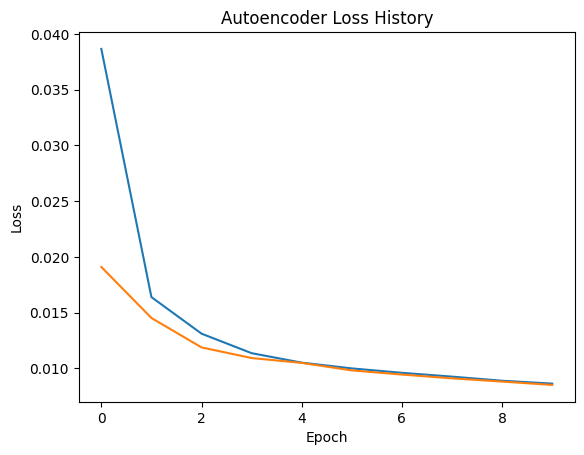

In [8]:
autoencoder = Autoencoder()
autoencoder.train(train_loader, test_loader, epochs=EPOCHS, lr=0.001)
autoencoder.plot_loss()

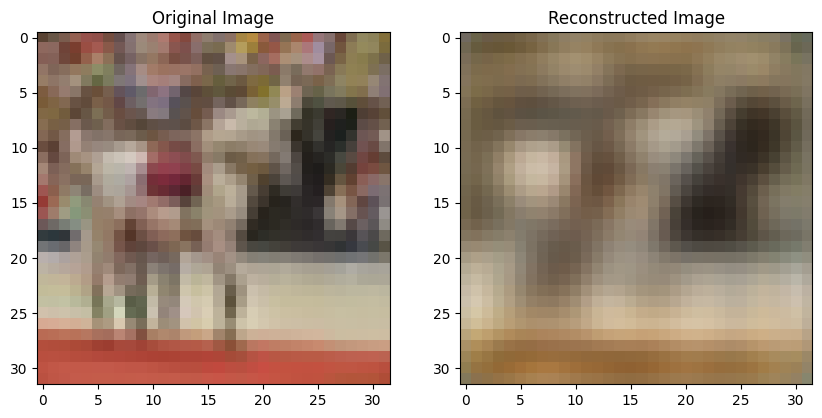

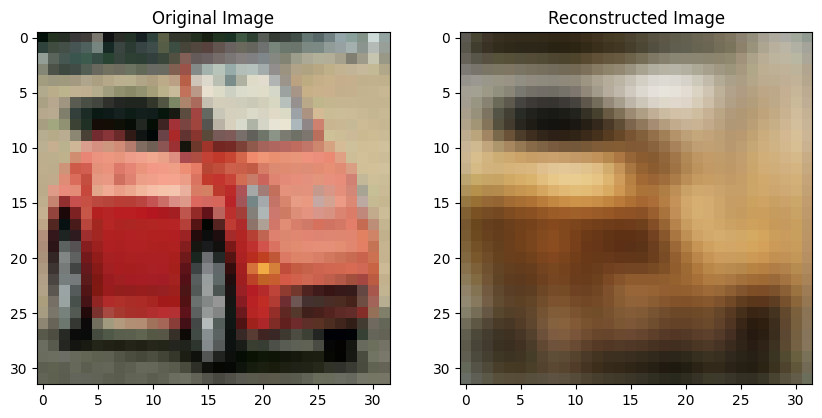

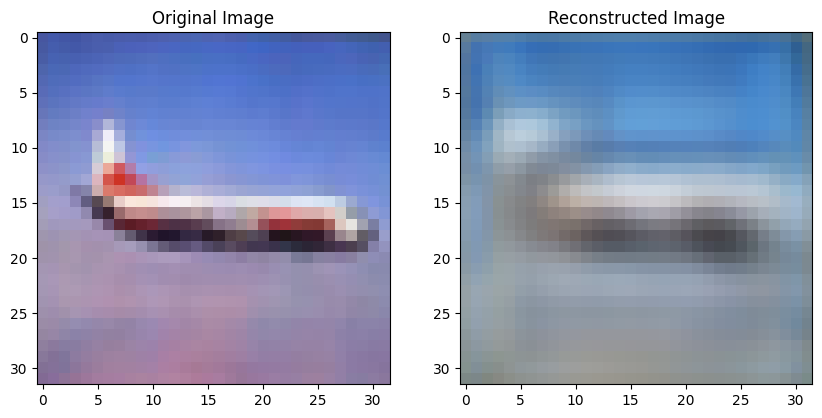

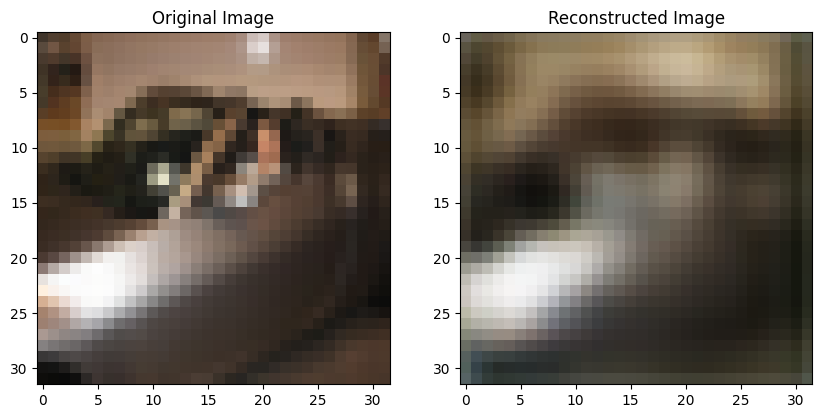

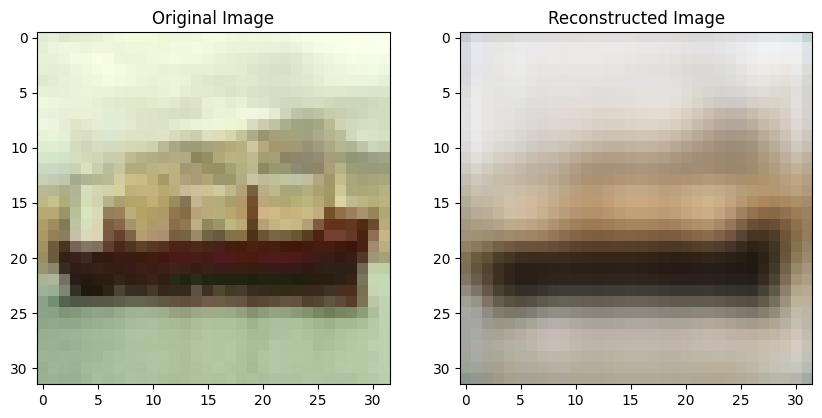

In [9]:
plot_examples(autoencoder, num_examples=N_EXAMPLES)

## Exercise 2

1. What is the size of the latent space representation of the above network?


To compute the size of the latent space representation we need to apply the following formula:
$$\left(\frac{W-K+2P}{S}+1\right)^2 \cdot C$$
in which:
- $W$ is the input volume
- $K$ is the kernel size
- $P$ is the padding
- $S$ is the stride
- $C$ is the number of channels

Applying that for each layer we get that:
Econder part:
- first convolutional layer: $32\cdot32\cdot8$
- first max pooling: $16\cdot 16 \cdot 8$
- second convolutional layer: $16\cdot16\cdot12$
- second max pooling: $8\cdot8\cdot12$
- third convolutional layer: $8\cdot8\cdot16$

Decoder part:
- first upsample layer: $3\cdot3\cdot16$
- first convolutional layer: $3\cdot3\cdot12$
- second upsample layer: $(\frac{3}{2})^2 \cdot 12$
- second convolutional layer: $3$


2. Try other architectures (e.g. fewer intermediate layers, different number of channels, filter sizes or stride and
padding configurations) to answer questions such as: What is the impact of those in the reconstruction error
after training? Is there an obvious correlation between the size of the latent space representation and the error?

In [10]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.7 MB/s eta 0:00:00


In [12]:
import optuna

def make_encoder_decoder(n_layers, m_factor):
  encoder_layers = []
  in_channels = 3
  channel_list = []
  for i in range(n_layers):
      out_channels = 8 + i * m_factor
      encoder_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
      encoder_layers.append(nn.ReLU(True))
      if i < n_layers - 1:
          encoder_layers.append(nn.MaxPool2d(2, 2))
      in_channels = out_channels
      channel_list.append(out_channels)
  encoder = nn.Sequential(*encoder_layers)

  # Build decoder
  decoder_layers = []
  channel_list = channel_list[::-1]
  in_channels = channel_list[0]
  for i in range(n_layers - 1):
      decoder_layers.append(nn.Upsample(scale_factor=2, mode="nearest"))
      out_channels = channel_list[i + 1]
      decoder_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
      decoder_layers.append(nn.ReLU(True))
      in_channels = out_channels
  decoder_layers.append(nn.Conv2d(in_channels, 3, kernel_size=3, stride=1, padding=1))
  decoder_layers.append(nn.Sigmoid())
  decoder = nn.Sequential(*decoder_layers)

  return encoder, decoder



def objective(trial):
  epochs = 5

  m_factor = trial.suggest_int("m_factor", 4, 16)
  n_layers = trial.suggest_int("n_layers", 1, 6)

  encoder, decoder = make_encoder_decoder(n_layers, m_factor)

  model = Autoencoder(encoder, decoder)
  model.train(train_loader, test_loader, epochs=epochs, lr=0.001)
  test_loss = model.test_loss(test_loader)

  return test_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print(study.best_params)

[I 2024-11-14 15:14:42,554] A new study created in memory with name: no-name-b700e70c-c3a6-495c-8359-45ccaab12c0c


Using CUDA (GPU)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/5 Train Loss: 0.05055911136390288, Test Loss: 0.03234405368566513
Epoch 2/5 Train Loss: 0.018137235954828277, Test Loss: 0.007983723189681768
Epoch 3/5 Train Loss: 0.005071437062954978, Test Loss: 0.003889380698092282
Epoch 4/5 Train Loss: 0.003536508238839009, Test Loss: 0.0033007344463840127
Epoch 5/5 Train Loss: 0.0030374944658030437, Test Loss: 0.002828474366106093


[I 2024-11-14 15:15:17,955] Trial 0 finished with value: 0.002828474366106093 and parameters: {'m_factor': 16, 'n_layers': 1}. Best is trial 0 with value: 0.002828474366106093.


Using CUDA (GPU)
Epoch 1/5 Train Loss: 0.03313779229699056, Test Loss: 0.012991935107856989
Epoch 2/5 Train Loss: 0.010905979790642291, Test Loss: 0.008289408590644597
Epoch 3/5 Train Loss: 0.007140276900527975, Test Loss: 0.00649021090939641
Epoch 4/5 Train Loss: 0.006191353979697333, Test Loss: 0.006003520917147398
Epoch 5/5 Train Loss: 0.005726595202908863, Test Loss: 0.00583036239258945


[I 2024-11-14 15:15:56,561] Trial 1 finished with value: 0.00583036239258945 and parameters: {'m_factor': 13, 'n_layers': 2}. Best is trial 0 with value: 0.002828474366106093.


Using CUDA (GPU)
Epoch 1/5 Train Loss: 0.04699792887402486, Test Loss: 0.029563629440963267
Epoch 2/5 Train Loss: 0.026316791301286672, Test Loss: 0.025100077502429485
Epoch 3/5 Train Loss: 0.02306713562317287, Test Loss: 0.021866456605494022
Epoch 4/5 Train Loss: 0.021350220388060885, Test Loss: 0.020834267139434814
Epoch 5/5 Train Loss: 0.02045441822066337, Test Loss: 0.021613727882504465


[I 2024-11-14 15:16:34,261] Trial 2 finished with value: 0.021613727882504465 and parameters: {'m_factor': 6, 'n_layers': 4}. Best is trial 0 with value: 0.002828474366106093.


Using CUDA (GPU)
Epoch 1/5 Train Loss: 0.056830208559956734, Test Loss: 0.04460298120975494
Epoch 2/5 Train Loss: 0.040615764222567595, Test Loss: 0.03794657774269581
Epoch 3/5 Train Loss: 0.03686446889857702, Test Loss: 0.03302975073456764
Epoch 4/5 Train Loss: 0.03195749640559094, Test Loss: 0.03179509975016117
Epoch 5/5 Train Loss: 0.03114680528546436, Test Loss: 0.030174083076417446


[I 2024-11-14 15:17:15,189] Trial 3 finished with value: 0.030174083076417446 and parameters: {'m_factor': 6, 'n_layers': 6}. Best is trial 0 with value: 0.002828474366106093.


Using CUDA (GPU)
Epoch 1/5 Train Loss: 0.04848500053527989, Test Loss: 0.034455516189336774
Epoch 2/5 Train Loss: 0.030695808249749715, Test Loss: 0.02860913835465908
Epoch 3/5 Train Loss: 0.027812373576850832, Test Loss: 0.02632071264088154
Epoch 4/5 Train Loss: 0.025832480550566805, Test Loss: 0.02511558886617422
Epoch 5/5 Train Loss: 0.02479081327402139, Test Loss: 0.02418992705643177


[I 2024-11-14 15:17:57,184] Trial 4 finished with value: 0.02418992705643177 and parameters: {'m_factor': 9, 'n_layers': 5}. Best is trial 0 with value: 0.002828474366106093.


Using CUDA (GPU)
Epoch 1/5 Train Loss: 0.0563317411873914, Test Loss: 0.044691020250320436
Epoch 2/5 Train Loss: 0.04009738314566733, Test Loss: 0.03854686431586742
Epoch 3/5 Train Loss: 0.035567663704292686, Test Loss: 0.032014261931180954
Epoch 4/5 Train Loss: 0.031493291518167606, Test Loss: 0.03136962782591581
Epoch 5/5 Train Loss: 0.031136827637689022, Test Loss: 0.03161520957946777


[I 2024-11-14 15:18:39,213] Trial 5 finished with value: 0.03161520957946777 and parameters: {'m_factor': 7, 'n_layers': 6}. Best is trial 0 with value: 0.002828474366106093.


Using CUDA (GPU)
Epoch 1/5 Train Loss: 0.04590768711287764, Test Loss: 0.026673411950469017
Epoch 2/5 Train Loss: 0.023578365533789503, Test Loss: 0.02149482648819685
Epoch 3/5 Train Loss: 0.018407353235385084, Test Loss: 0.01689944677054882
Epoch 4/5 Train Loss: 0.016234901049940645, Test Loss: 0.015226565860211849
Epoch 5/5 Train Loss: 0.014937822152919408, Test Loss: 0.01435857405886054


[I 2024-11-14 15:19:21,210] Trial 6 finished with value: 0.01435857405886054 and parameters: {'m_factor': 14, 'n_layers': 4}. Best is trial 0 with value: 0.002828474366106093.


Using CUDA (GPU)
Epoch 1/5 Train Loss: 0.035069043877758554, Test Loss: 0.019874592870473863
Epoch 2/5 Train Loss: 0.01870865296996847, Test Loss: 0.017230461165308953
Epoch 3/5 Train Loss: 0.016748253986993922, Test Loss: 0.016256436705589294
Epoch 4/5 Train Loss: 0.015347105450928211, Test Loss: 0.016402091085910796
Epoch 5/5 Train Loss: 0.01354356405997201, Test Loss: 0.011966325901448726


[I 2024-11-14 15:20:08,232] Trial 7 finished with value: 0.011966325901448726 and parameters: {'m_factor': 10, 'n_layers': 3}. Best is trial 0 with value: 0.002828474366106093.


Using CUDA (GPU)
Epoch 1/5 Train Loss: 0.04681561467579649, Test Loss: 0.028228843584656715
Epoch 2/5 Train Loss: 0.01678570947032186, Test Loss: 0.010109196975827217
Epoch 3/5 Train Loss: 0.00762235546555323, Test Loss: 0.005576675618067383
Epoch 4/5 Train Loss: 0.004611129312528463, Test Loss: 0.004021379537880421
Epoch 5/5 Train Loss: 0.0036704676060736936, Test Loss: 0.003371630539186299


[I 2024-11-14 15:20:51,753] Trial 8 finished with value: 0.003371630539186299 and parameters: {'m_factor': 9, 'n_layers': 1}. Best is trial 0 with value: 0.002828474366106093.


Using CUDA (GPU)
Epoch 1/5 Train Loss: 0.040593198253006876, Test Loss: 0.026035169884562493
Epoch 2/5 Train Loss: 0.023413909363407124, Test Loss: 0.021105452068150045
Epoch 3/5 Train Loss: 0.020331436225885076, Test Loss: 0.019607444852590562
Epoch 4/5 Train Loss: 0.01837680198818068, Test Loss: 0.01751979663968086
Epoch 5/5 Train Loss: 0.0166693319554759, Test Loss: 0.015624153800308705


[I 2024-11-14 15:21:31,746] Trial 9 finished with value: 0.015624153800308705 and parameters: {'m_factor': 15, 'n_layers': 4}. Best is trial 0 with value: 0.002828474366106093.


{'m_factor': 16, 'n_layers': 1}


Using CUDA (GPU)
Epoch 1/10 Train Loss: 0.04707596724546408, Test Loss: 0.026483631692826748
Epoch 2/10 Train Loss: 0.013744007017982156, Test Loss: 0.0061666632536798716
Epoch 3/10 Train Loss: 0.0046321888501414015, Test Loss: 0.003854731656610966
Epoch 4/10 Train Loss: 0.003515638661559058, Test Loss: 0.003215941949747503
Epoch 5/10 Train Loss: 0.0029839013785689693, Test Loss: 0.002752342843450606
Epoch 6/10 Train Loss: 0.002608115728826651, Test Loss: 0.002438913844525814
Epoch 7/10 Train Loss: 0.0023361579986595654, Test Loss: 0.002197058545425534
Epoch 8/10 Train Loss: 0.0021129585183638183, Test Loss: 0.0019965597777627407
Epoch 9/10 Train Loss: 0.0019299190394179541, Test Loss: 0.001826300087850541
Epoch 10/10 Train Loss: 0.0017756107985336758, Test Loss: 0.0017023688182234765


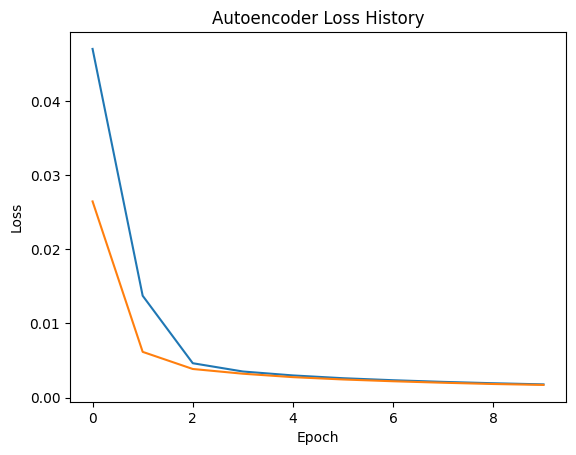

In [13]:
best_encoder, best_decoder = make_encoder_decoder(study.best_params['n_layers'], study.best_params['m_factor'])
best_model = Autoencoder(encoder=best_encoder, decoder=best_decoder)
best_model.train(train_loader, test_loader, epochs=EPOCHS, lr=0.001)
best_model.plot_loss()

In [17]:
best_encoder, best_decoder

(Sequential(
   (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace=True)
 ),
 Sequential(
   (0): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): Sigmoid()
 ))

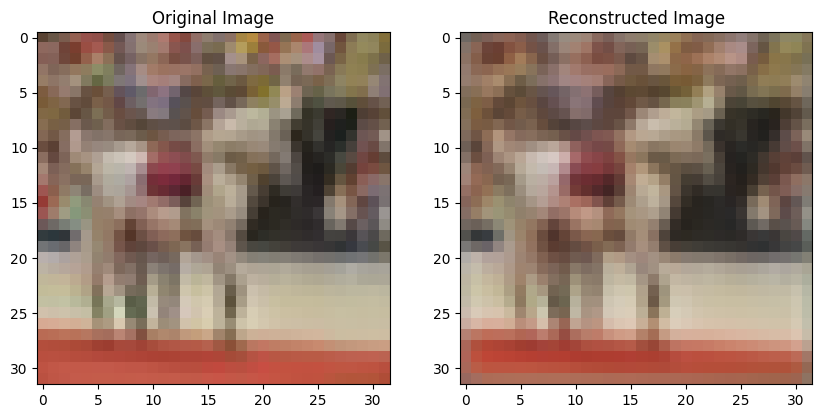

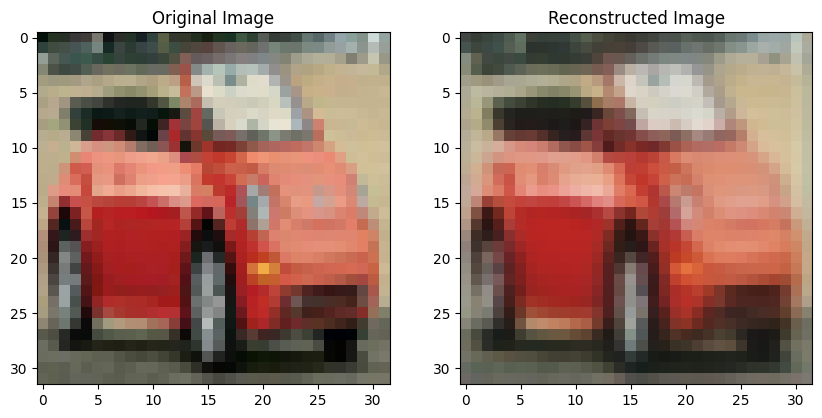

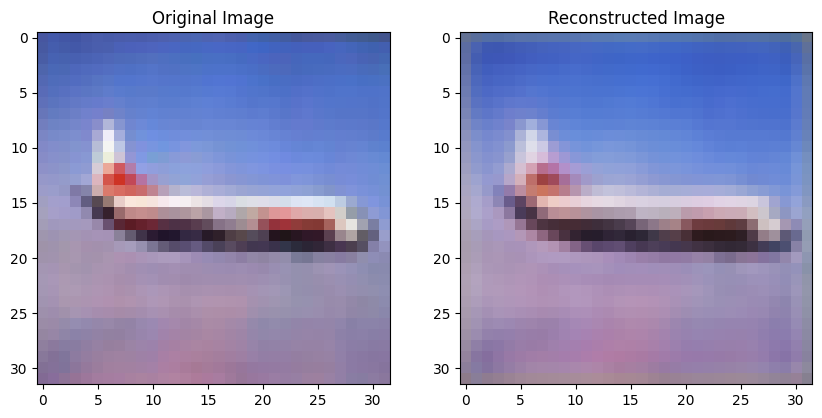

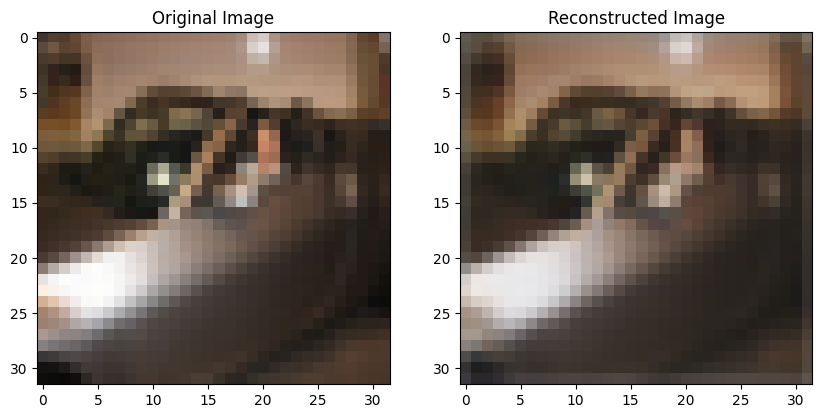

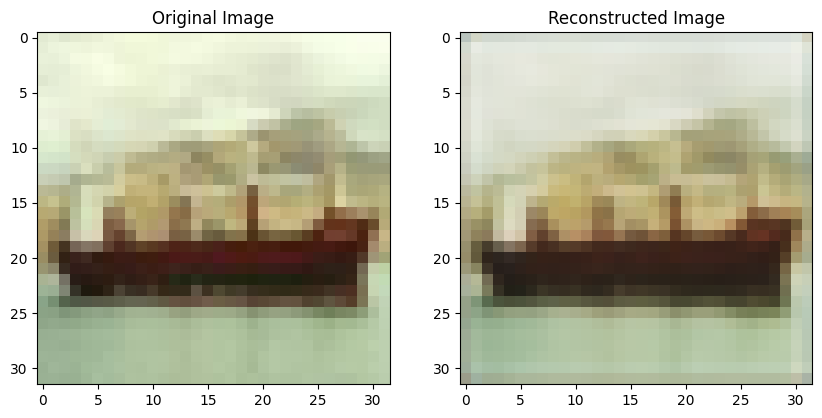

In [14]:
plot_examples(best_model, num_examples=N_EXAMPLES)

i risultati andrebbero magari rappresentati in some way per rispondere bene alle domande. capiamo se ha senso sto metodo.

## Exercise 3


1. Adapt your network from the previous part such that it learns to reconstruct colors by feeding in grayscale
images but predicting all RGB channels. As a starting point, use the hyperparameters (including the network
architecture) that you identified to yield the best performance in Exercise 2.

Using CUDA (GPU)
Epoch 1/10 Train Loss: 0.03685367906678327, Test Loss: 0.020947160385549068
Epoch 2/10 Train Loss: 0.01727786238152015, Test Loss: 0.016477411426603795
Epoch 3/10 Train Loss: 0.014869448622759384, Test Loss: 0.015304553508758544
Epoch 4/10 Train Loss: 0.013868281570605085, Test Loss: 0.014799586497247219
Epoch 5/10 Train Loss: 0.013160280506067637, Test Loss: 0.014505682699382304
Epoch 6/10 Train Loss: 0.012664400406559057, Test Loss: 0.01403954615816474
Epoch 7/10 Train Loss: 0.012273333589487437, Test Loss: 0.013896162621676922
Epoch 8/10 Train Loss: 0.012012096204429487, Test Loss: 0.013906370289623738
Epoch 9/10 Train Loss: 0.011768237451869475, Test Loss: 0.013924382533878088
Epoch 10/10 Train Loss: 0.011524622788346267, Test Loss: 0.013709696568548679


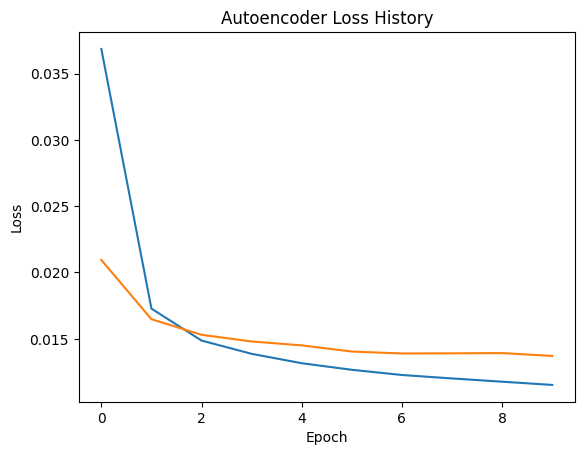

In [15]:
autoencoder_gray = Autoencoder()
autoencoder_gray.train(
    train_loader, test_loader, epochs=EPOCHS, lr=0.001, grayscale_input=True
)
autoencoder_gray.plot_loss()

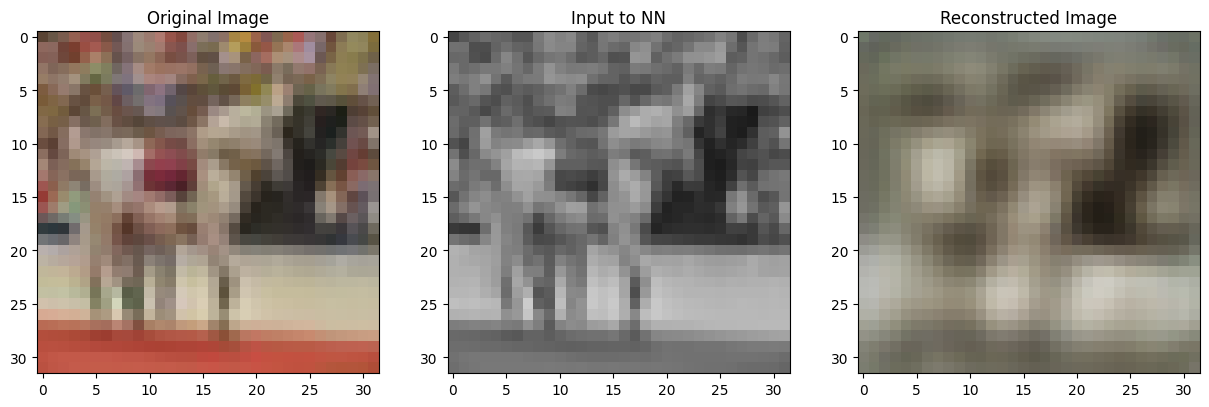

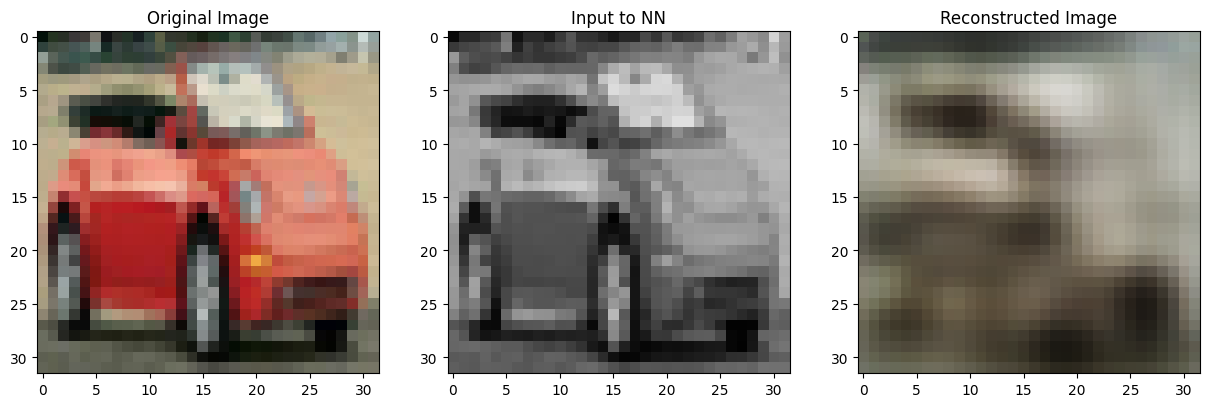

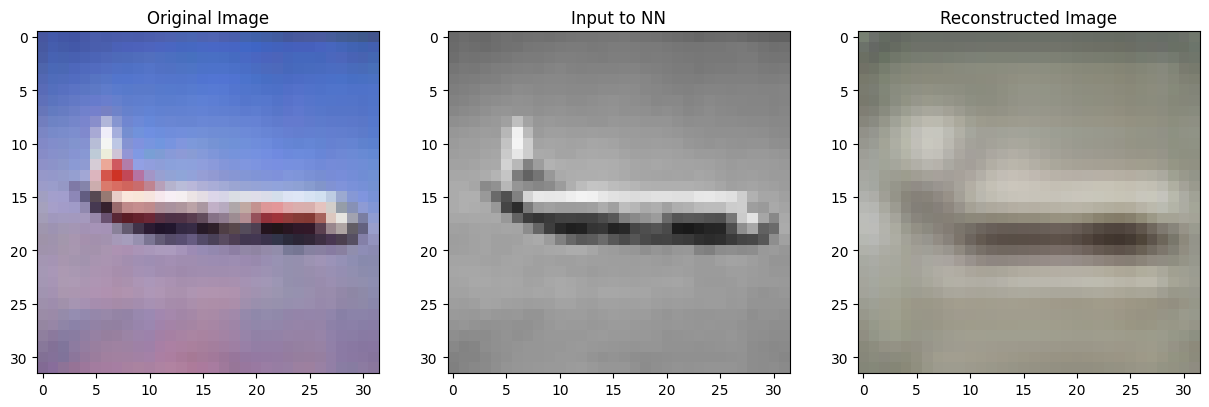

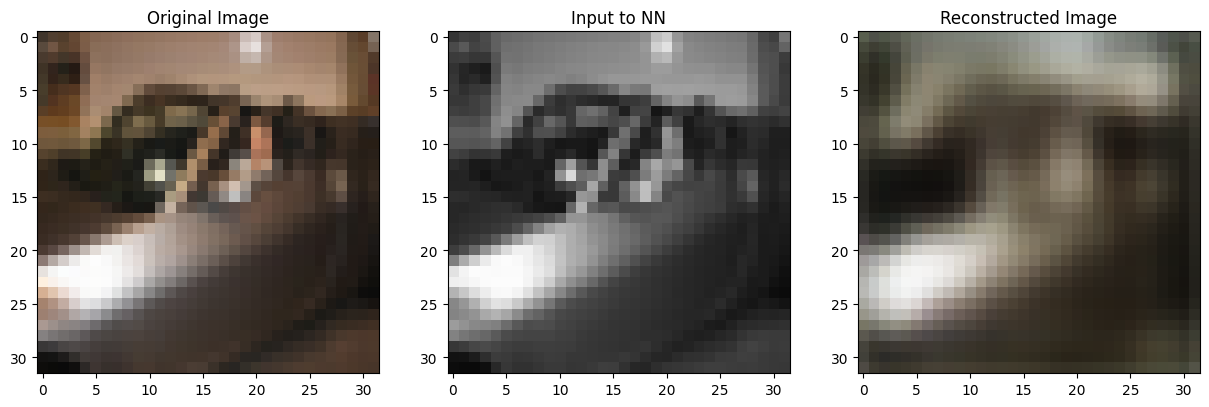

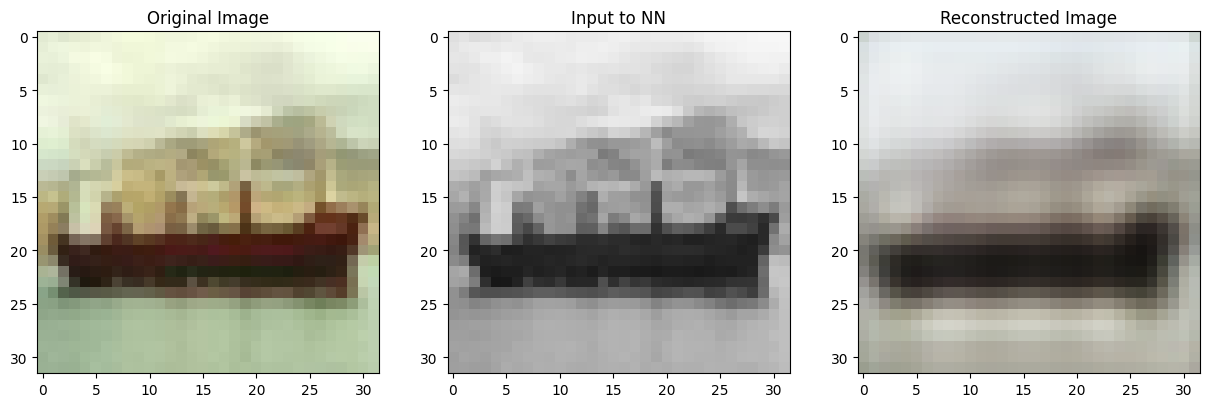

In [16]:
plot_examples(autoencoder_gray, num_examples=N_EXAMPLES, grayscale=True)

2. Report on your results and reason about potential shortcomings of your network. What aspects of the architecture/hyperparameters/optimization could be improved upon to fit the model more adequately to this application? Try out some ideas.

Per quello che è riuscito a fare:

The loss around 0.0069 is relatively low, suggesting good reconstruction performance.  <br>
The model using 2 convolutional layers in the encoder and decoder with 8 and 12 channels respectively seems to work well. This suggests a relatively simpler architecture can be effective for this task.<br>

Learning rate (0.001) seems appropriate for this task and 10 epochs appear sufficient for convergence, at least for this specific architecture and hyperparameter combination.

Using CUDA (GPU)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10 Train Loss: 0.04836387663513799, Test Loss: 0.035986882820725444
Epoch 2/10 Train Loss: 0.019321244622616075, Test Loss: 0.015483124647289515
Epoch 3/10 Train Loss: 0.009266909636274169, Test Loss: 0.012959739752113819
Epoch 4/10 Train Loss: 0.008315515327208403, Test Loss: 0.012511187884956598
Epoch 5/10 Train Loss: 0.007956269485993853, Test Loss: 0.01221113298088312
Epoch 6/10 Train Loss: 0.0076263154314571546, Test Loss: 0.011896583531051875
Epoch 7/10 Train Loss: 0.007357269867405861, Test Loss: 0.011704683117568494
Epoch 8/10 Train Loss: 0.007143346127122641, Test Loss: 0.011517132539302111
Epoch 9/10 Train Loss: 0.007012531786119636, Test Loss: 0.011328133195638657
Epoch 10/10 Train Loss: 0.006923886941439366, Test Loss: 0.011360666807740926


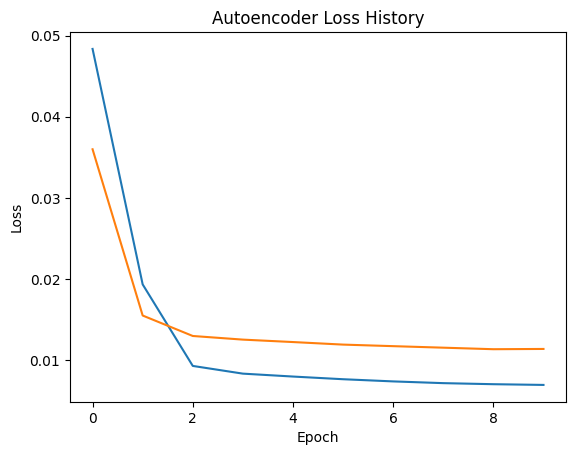

In [18]:
best_encoder, best_decoder = make_encoder_decoder(study.best_params['n_layers'], study.best_params['m_factor'])
best_model_gray = Autoencoder(encoder=best_encoder, decoder=best_decoder)
best_model_gray.train(train_loader, test_loader, epochs=EPOCHS, lr=0.001,grayscale_input=True)
best_model_gray.plot_loss()

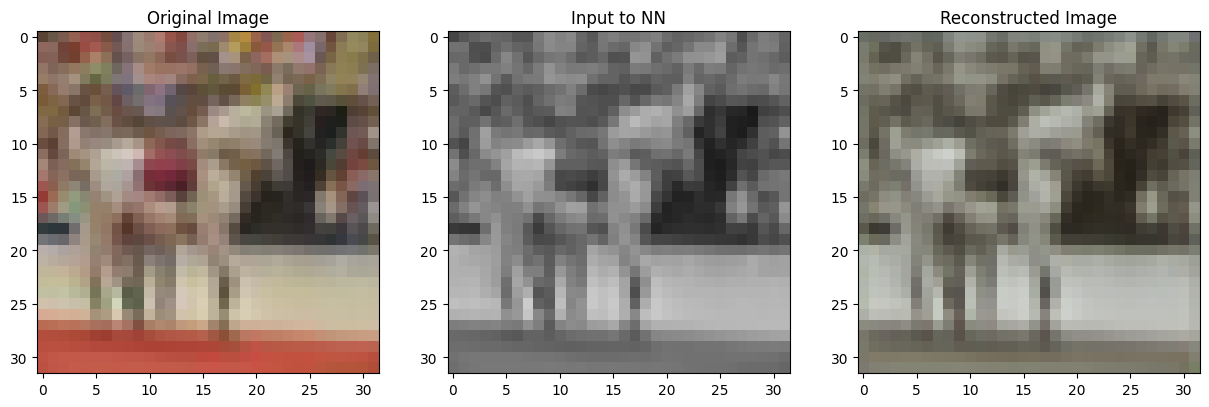

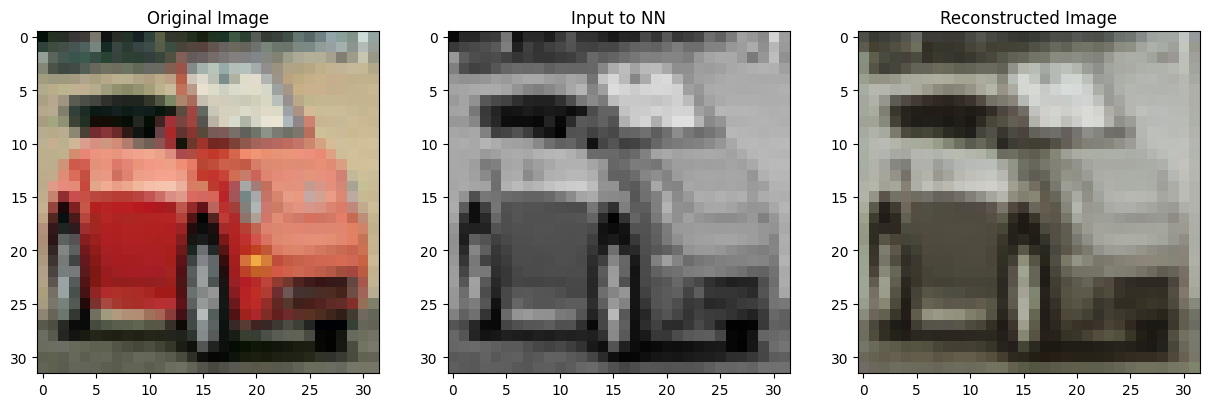

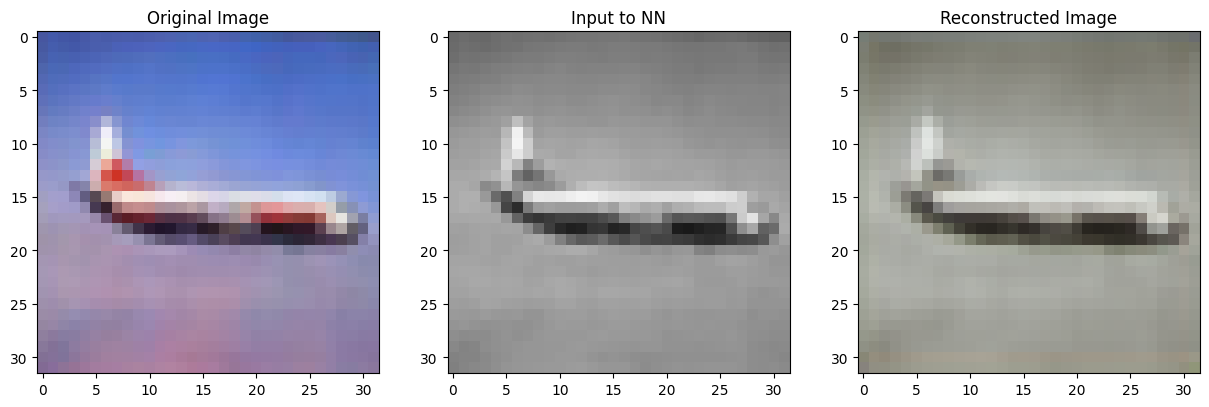

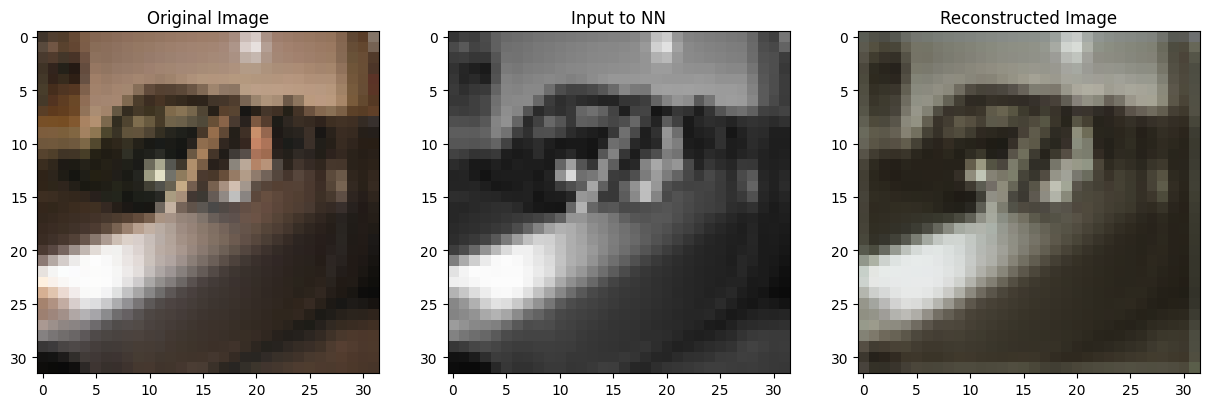

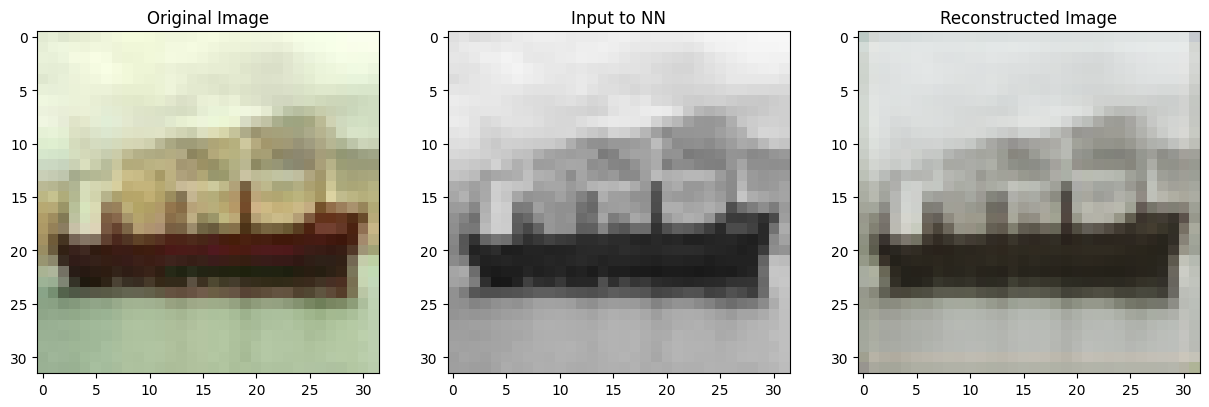

In [19]:
plot_examples(best_model_gray, num_examples=N_EXAMPLES, grayscale=True)